# **Previsão de incumprimento nas aplicações de cartões de crédito**

Há momentos que os clientes se deparam com dificuldades financeiras e geralmente não acontece só uma vez. Por isso é necessário trabalhar com indicadores que antecipem esse resultado final, tais como: pagamentos atrasados, chamadas para os serviços ao cliente, consultas sobre os produtos, um padrão de navegação diferente na web ou na aplicação móvel. Ao utuilizar tais padrões é possível de forma significativa previnir o até mesmo orientar o processo e prestar um melhor serviço ao cliente, assim também diminuindo o prejuízo e o risco para o banco.

**Sinopse:**


*   Obtenção dos dados
*   Preparação de dados
*   Análise descritiva
*   Engenharia de características
*   Redução da dimensionalidade
*   Modelação
*   Explicabilidade

**Informações do conjunto de dados**

Este conjunto de dados contém informações sobre pagamentos inadimplentes, fatores demográficos, dados de crédito, histórico de pagamento e extratos de contas de clientes de cartão de crédito em Taiwan de abril de 2005 a setembro de 2005.

**Existem 25 variáveis**

*   ID : ID de cada cliente
*   LIMIT_BAL : Valor do crédito concedido em dólares do NT (inclui crédito individual e familiar / suplementar
*   SEXO : Gênero (1 = masculino, 2 = feminino)
*   EDUCAÇÃO : (1 = pós-graduação, 2 = universidade, 3 = ensino médio, 4 = outros, 5 = desconhecido, 6 = desconhecido)
*   CASAMENTO : Estado civil (1 = casado, 2 = solteiro, 3 = outros)
*   IDADE : Idade em anos
*   PAY_0 : Status de reembolso em setembro de 2005 (-1 = pagamento devidamente, 1 = atraso no pagamento por um mês, 2 = atraso no pagamento por dois meses, ... 8 = atraso no pagamento por oito meses, 9 = atraso no pagamento por nove meses e acima)
*   PAY_2 : Status de reembolso em agosto de 2005 (escala igual à acima)
*   PAY_3 : Status de reembolso em julho de 2005 (escala igual à acima)
*   PAY_4 : Status de reembolso em junho de 2005 (escala igual à acima)
*   PAY_5 : Status de reembolso em maio de 2005 (escala igual à acima)
*   PAY_6 : Status de reembolso em abril de 2005 (escala igual à anterior)
*   BILL_AMT1 : Valor da fatura em setembro de 2005 (dólar NT)
*   BILL_AMT2 : Valor da fatura em agosto de 2005 (dólar NT)
*   BILL_AMT3 : Valor da fatura em julho de 2005 (dólar NT)
*   BILL_AMT4 : Valor da fatura em junho de 2005 (dólar NT)
*   BILL_AMT5 : Valor da fatura em maio de 2005 (dólar NT)
*   BILL_AMT6 : Valor da fatura em abril de 2005 (dólar NT)
*   PAY_AMT1 : Valor do pagamento anterior em setembro de 2005 (dólar NT)
*   PAY_AMT2 : Valor do pagamento anterior em agosto de 2005 (dólar NT)
*   PAY_AMT3 : Valor do pagamento anterior em julho de 2005 (dólar NT)
*   PAY_AMT4 : Valor do pagamento anterior em junho de 2005 (dólar NT)
*   PAY_AMT5 : Valor do pagamento anterior em maio de 2005 (dólar NT)
*   PAY_AMT6 : Valor do pagamento anterior em abril de 2005 (dólar NT)
*   default.payment.next.month : Pagamento padrão (1 = sim, 0 = não)



In [3]:
import numpy as np
import pandas as pd

from datetime import datetime

import re

%matplotlib inline
import matplotlib.pyplot as plt

#defaults
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

In [4]:
df = pd.read_csv('UCI_Credit_Card.csv')

In [5]:
df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1.0
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1.0
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0.0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0.0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0.0


**Limpar**

Baixamos o nome da coluna, e renomeamos os nomes da coluna quando necessário, Em particular, este conjunto de dados falha um colum PAY_1. Na análise aqui abaixo assumimos que PAY_0 é realmente pay_1, para ser considerado o reembolso do mês anterior ao mês em que calculamos o incumprimento (que é Outubro de 2005, neste conjunto de dados em particular).

In [6]:
df.columns = [x.lower() for x in df.columns]
df = df.rename(index=str, columns={"pay_0": "pay_1"})
df = df.drop('id', axis=1)
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default.payment.next.month'],
      dtype='object')

In [7]:
print("Variáveis exploratórias: {}".format(len(df.columns)-1))
print("Número de observações: {}".format(df.shape[0]))

df['target'] = df['default.payment.next.month'].astype('category')

# criar uma coluna 'alvo' para a nossa própria conveniência
print("Variável target:       '{}' -> '{}'".format('default.payment.next.month', 'target'))

Variáveis exploratórias: 23
Número de observações: 11109
Variável target:       'default.payment.next.month' -> 'target'


# **Análise descritiva**

**Atrasos de pagamentos**

Comecemos por olhar para os atrasos de pagamento passados

In [8]:
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]

df[pay_status_columns].head(10)

,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6
0,2,2,-1,-1,-2,-2
1,-1,2,0,0,0,2
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,-1,0,-1,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0
7,0,-1,-1,0,0,-1
8,0,0,2,0,0,0
9,-2,-2,-2,-2,-1,-1


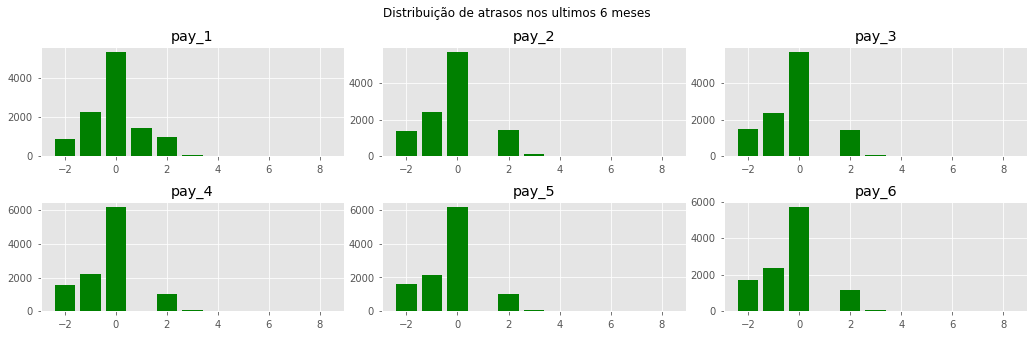

In [9]:
# pay status columns
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]

fig, ax = plt.subplots(2,3)
fig.set_size_inches(15,5)
fig.suptitle('Distribuição de atrasos nos ultimos 6 meses')

for i in range(len(pay_status_columns)):
    row,col = int(i/3), i%3

    d  = df[pay_status_columns[i]].value_counts()
    ax[row,col].bar(d.index, d, align='center', color='g')
    ax[row,col].set_title(pay_status_columns[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()
  

Como pode ver, algumas pessoas pagam 2 meses adiantados, outras um mês adiantado, a maioria está ao par. Algumas estão atrasadas nos pagamentos. Uma coisa que vale a pena notar é que as informações textuais fornecidas sobre estas variáveis e os valores reais não são exctamente os mesmos. Por isso, antes de proceder a qualquer análise, procure e explore sempre os dados, explorando e verificando os dados reais e as informações textuais sobre os dados em si.



**Crédito**

Vejamos agora como as dívidas/créditos se acumulam ao longo dos meses, o crédito a ser reembolsado é um número positivo aqui.

In [10]:
pattern = re.compile("^bill_amt[0-9]+$")
bill_collumns = [x for x in df.columns if (pattern.match(x))]
df[bill_collumns].describe()

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
count,11108.000000,11108.000000,1.110800e+04,11108.000000,11108.000000,11108.000000
mean,49877.236136,47955.361721,4.519021e+04,40416.910695,39153.584174,37728.507022
std,72196.769699,70085.931812,6.785330e+04,61318.434825,59428.192388,59139.263814
min,-15308.000000,-33350.000000,-3.404100e+04,-170000.000000,-28335.000000,-339603.000000
25%,3374.750000,2855.000000,2.466250e+03,1939.750000,1487.500000,982.000000
50%,21992.000000,21085.500000,1.974350e+04,18474.500000,17705.500000,16319.000000
75%,64428.750000,61979.250000,5.808225e+04,49648.750000,49227.750000,48113.500000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


In [11]:
df[bill_collumns].head(10)

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
0,3913.0,3102.0,689.0,0.0,0.0,0.0
1,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0
2,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0
3,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0
4,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0
5,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0
6,367965.0,412023.0,445007.0,542653.0,483003.0,473944.0
7,11876.0,380.0,601.0,221.0,-159.0,567.0
8,11285.0,14096.0,12108.0,12211.0,11793.0,3719.0
9,0.0,0.0,0.0,0.0,13007.0,13912.0


**Pagamentos nos meses anteriores**

Vejamos rapidamente como são efetuados os pagamentos no mês anterior.

In [12]:
pattern = re.compile("^pay_amt[0-9]+$")
pay_amount_columns =[ x for x in df.columns if (pattern.match(x))]
df[pay_status_columns].describe()

,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6
count,11109.000000,11109.000000,11109.000000,11109.000000,11109.000000,11109.000000
mean,0.003061,-0.143307,-0.164371,-0.243316,-0.259519,-0.280853
std,1.120965,1.203533,1.215961,1.139580,1.128525,1.160730
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [13]:
df[pay_amount_columns].head(10)

,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,0.0,689.0,0.0,0.0,0.0,0.0
1,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,2000.0,36681.0,10000.0,9000.0,689.0,679.0
5,2500.0,1815.0,657.0,1000.0,1000.0,800.0
6,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0
7,380.0,601.0,0.0,581.0,1687.0,1542.0
8,3329.0,0.0,432.0,1000.0,1000.0,1000.0
9,0.0,0.0,0.0,13007.0,1122.0,0.0


In [14]:
df['limit_bal'].describe()

count      11109.00000
mean      166153.20911
std       130304.04296
min        10000.00000
25%        50000.00000
50%       140000.00000
75%       240000.00000
max      1000000.00000
Name: limit_bal, dtype: float64

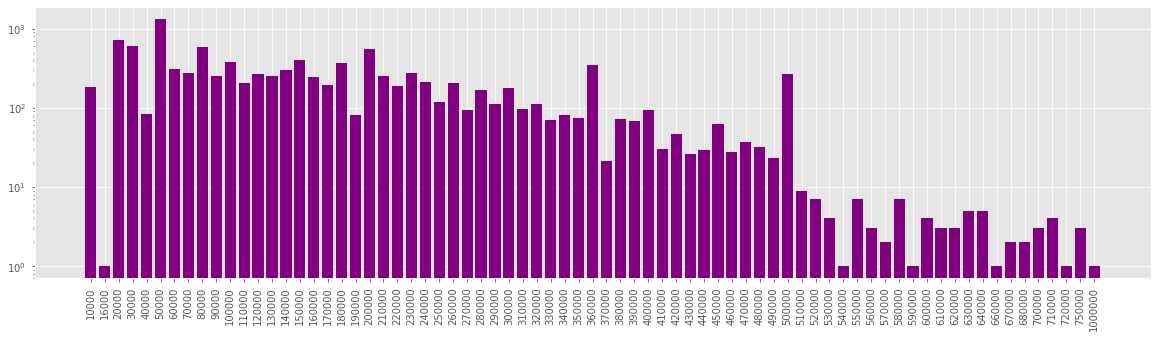

In [15]:
#saldo limite

fig = plt.figure()
fig.set_size_inches(20,5)
ax = fig.add_subplot(111)

d = df.groupby(['limit_bal']).size()
ax.set_yscale("log")
ax.set_xticks(np.arange(len(d)))
ax.set_xticklabels(['%d' % i for i in d.index], rotation='vertical')
p = ax.bar(np.arange(len(d)), d, color='purple')

**Explorar o incumprimento**

Em primeiro lugar, vamos começar com uma vista ampliada sobre o problema.
Queremos prever o incumprimento, Vamos responder às seguintes perguntas:



*   Nossa variável target está balanceada?
*   Qual é a repartição, dependendo de algumas das variáveis disponíveis?



Contas em atrasão são de 22.542311847317247% de 11108 observações


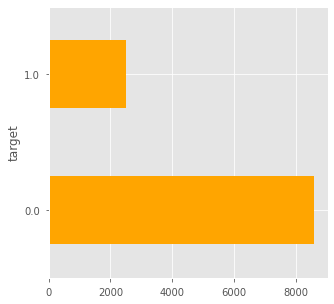

In [16]:
fig = plt.figure()
fig.set_size_inches(5,5)
d = df.groupby(['target']).size()
print("Contas em atrasão são de {}% de {} observações".format(100* d[1]/(d[1]+d[0]), d[1]+d[0]))
p = d.plot(kind='barh', color='orange')

Observamos um nítido desbalanceamento de classe que precisa ser tratado posteriormente.

**Explorar algumas estatísticas de incumprimento utilizando as variáveis categóricas**

Vamos dar uma vista de olhos a vários histogramas para ver como o padrão se correlaciona com as variáveis categóricas disponíveis, antes disso vamos fazer uso das características categóricas dos pandas, convertendo as colunas alvo, sexo, casamento, educação, idade e pagamento em categorias

In [17]:
df['sex'] = df['sex'].astype('category').cat.rename_categories(['M', 'F'])
df['marriage'] = df['marriage'].astype('category').cat.rename_categories(['na', 'married', 'single', 'other'])

In [18]:
df['age_cat'] = pd.cut(df['age'], range(0, 100, 10), right=False)

In [19]:
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]
for i in pay_status_columns:
    df[i] = df[i].astype('category')

**Estatísticas absolutas**

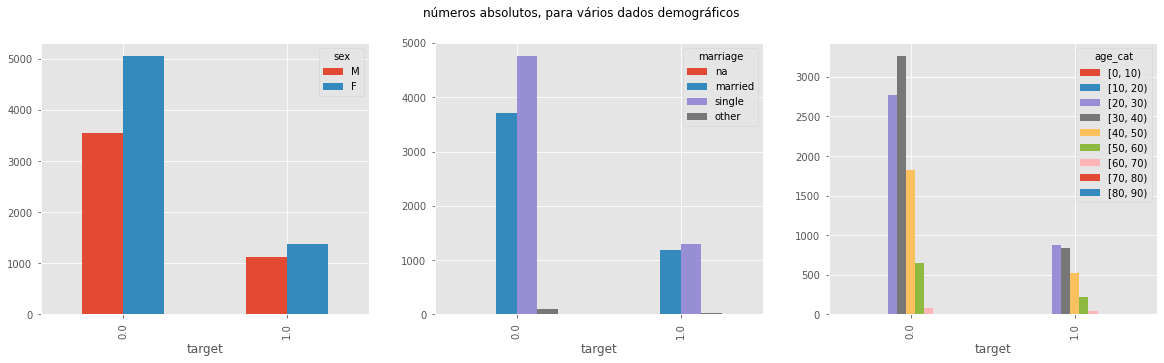

In [20]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('números absolutos, para vários dados demográficos')

d = df.groupby(['target', 'sex']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[1])

d = df.groupby(['target', 'age_cat']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[2])

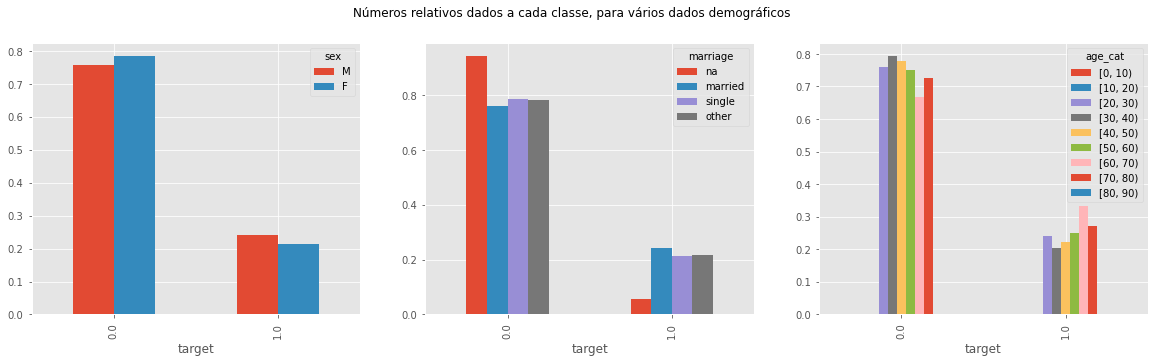

In [21]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Números relativos dados a cada classe, para vários dados demográficos')

d = df.groupby(['target', 'sex']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[1])

d = df.groupby(['target', 'age_cat']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[2])

**Engenharia de características**

Não se trata de conversão de características cegas para valores entre 0 e 1, trata-se de compreender os dados. Neste caso, vemos que os pagamentos exibem uma distribuição log/log, por isso, em primeiro lugar, vamos tirar o log dos pagamentos.

In [22]:
# help func
def selcols(prefix, a=1, b=6):
    return [prefix+str(i) for i in np.arange(a,b+1)]

In [23]:
from math import log

# estado de pagamento da média e do desvio padrão
df['pay_avg'] = df[selcols('pay_')].mean(axis=1)
df['pay_std'] = df[selcols('pay_')].std(axis=1)

In [24]:
# pagamento médio
df['pay_amt_avg']     = df[selcols('pay_amt')].mean(axis=1)

# log da média
df['pay_amt_avg_log'] = df['pay_amt_avg'].apply(lambda x: log(x+1))

#montantes relativos ao pagamento médio

for i in np.arange(1,7):
    df['pay_relamt'+str(i)] = df['pay_amt'+str(i)]/df['pay_amt_avg']

# log dos pagamentos
for i in np.arange(1,7):
    df['pay_amt_log'+str(i)] = df['pay_amt'+str(i)].apply(lambda x: log(x+1))

In [25]:
 # fatura média
df['bill_amt_avg'] = df[selcols('bill_amt')].mean(axis=1)
df['bill_amt_avg_log'] = df['bill_amt_avg'].apply(lambda x: log(x+1) if x>0 else 0)

# sinal de fatura como uma característica separada
for i in np.arange(1,7):
    df['bill_amt_sign'+str(i)] = df['bill_amt'+str(i)].apply(lambda x: float(x>0))
    
# registo da fatura como uma característica separada (0 se a fatura for negativa)
for i in np.arange(1,7):
    df['bill_amt_log'+str(i)] = df['bill_amt'+str(i)].apply(lambda x: log(x+1) if x>0 else 0)
    
#montantes de fatura relativos ao limite
for i in np.arange(1,7):
    df['bill_relamt'+str(i)] = df['bill_amt'+str(i)]/df['limit_bal']

In [26]:
#log do limite de crédito
df['limit_bal_log'] = df['limit_bal'].apply(lambda x: log(x+1))
df['limit_bal_cat'] = pd.cut(df['limit_bal'], range(0, int(1e6), 10000), right=False)

In [27]:
df.head(10)

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default.payment.next.month,target,age_cat,pay_avg,pay_std,pay_amt_avg,pay_amt_avg_log,pay_relamt1,pay_relamt2,pay_relamt3,pay_relamt4,pay_relamt5,pay_relamt6,pay_amt_log1,pay_amt_log2,pay_amt_log3,pay_amt_log4,pay_amt_log5,pay_amt_log6,bill_amt_avg,bill_amt_avg_log,bill_amt_sign1,bill_amt_sign2,bill_amt_sign3,bill_amt_sign4,bill_amt_sign5,bill_amt_sign6,bill_amt_log1,bill_amt_log2,bill_amt_log3,bill_amt_log4,bill_amt_log5,bill_amt_log6,bill_relamt1,bill_relamt2,bill_relamt3,bill_relamt4,bill_relamt5,bill_relamt6,limit_bal_log,limit_bal_cat
0,20000.0,F,2,married,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1.0,1.0,"[20, 30)",-0.333333,1.861899,114.833333,4.752152,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.536692,0.000000,0.000000,0.000000,0.000000,1284.000000,7.158514,1.0,1.0,1.0,0.0,0.0,0.0,8.272315,8.040125,6.536692,0.000000,0.000000,0.000000,0.195650,0.155100,0.034450,0.000000,0.000000,0.000000,9.903538,"[20000, 30000)"
1,120000.0,F,2,single,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1.0,1.0,"[20, 30)",0.500000,1.224745,833.333333,6.726633,0.000000,1.200000,1.200000,1.200000,0.000000,2.400000,0.000000,6.908755,6.908755,6.908755,0.000000,7.601402,2846.166667,7.954080,1.0,1.0,1.0,1.0,1.0,1.0,7.894691,7.453562,7.894691,8.093462,8.147867,8.090096,0.022350,0.014375,0.022350,0.027267,0.028792,0.027175,11.695255,"[120000, 130000)"
2,90000.0,F,2,single,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0.0,0.0,"[30, 40)",0.000000,0.000000,1836.333333,7.516071,0.826647,0.816845,0.544563,0.544563,0.544563,2.722817,7.325808,7.313887,6.908755,6.908755,6.908755,8.517393,16942.166667,9.737620,1.0,1.0,1.0,1.0,1.0,1.0,10.283293,9.548811,9.514880,9.570250,9.612400,9.651816,0.324878,0.155856,0.150656,0.159233,0.166089,0.172767,11.407576,"[90000, 100000)"
3,50000.0,F,2,married,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0.0,0.0,"[30, 40)",0.000000,0.000000,1398.000000,7.243513,1.430615,1.444206,0.858369,0.786838,0.764664,0.715308,7.601402,7.610853,7.090910,7.003974,6.975414,6.908755,38555.666667,10.559884,1.0,1.0,1.0,1.0,1.0,1.0,10.757711,10.783819,10.805517,10.251147,10.273671,10.293771,0.939800,0.964660,0.985820,0.566280,0.579180,0.590940,10.819798,"[50000, 60000)"
4,50000.0,M,2,married,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0.0,0.0,"[50, 60)",-0.333333,0.516398,9841.500000,9.194465,0.203221,3.727176,1.016105,0.914495,0.070010,0.068994,7.601402,10.510041,9.210440,9.105091,6.536692,6.522093,18223.166667,9.810504,1.0,1.0,1.0,1.0,1.0,1.0,9.061608,8.643121,10.486708,9.949464,9.859901,9.859118,0.172340,0.113400,0.716700,0.418800,0.382920,0.382620,10.819798,"[50000, 60000)"
5,50000.0,M,1,single,37,0,0,0,0,0,0,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0.0,0.0,"[30, 40)",0.000000,0.000000,1295.333333,7.167295,1.930005,1.401184,0.507205,0.772002,0.772002,0.617602,7.824446,7.504392,6.489205,6.908755,6.908755,6.685861,39685.666667,10.588771,1.0,1.0,1.0,1.0,1.0,1.0,11.072884,10.952034,10.961434,9.872771,9.884305,9.904737,1.288000,1.141380,1.152160,0.387880,0.392380,0.400480,10.819798,"[50000, 60000)"
6,500000.0,M,1,single,29,0,0,0,0,0,0,367965.0,412023.0,445007.0,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0.0,0.0,"[20, 30)",0.000000,0.000000,30126.500000,10.313194,1.825635,1.327735,1.261348,0.671801,0.456409,0.457073,10.915107,10.596660,10.545368,9.915416,9.528867,9.530320,454099.166667,13.026073,1.0,1.0,1.0,1.0,1.0,1.0,12.815746,12.928837,13.005848,13.204227,13.087780,13.068847,0.735930,0.824046,0.890014,1.0853

**Das variáveis ao treino, teste de matrizes**

In [28]:
from patsy import dmatrices

formula  = 'target ~ '

# features originais
formula += 'C(sex) + C(marriage) +  C(education) + age'
formula += '+' + '+'.join(selcols('pay_'))

#### engenharia /  features normalizadas

# limite categórico de idade e de crédito (em caixa)
formula += '+' + 'C(age_cat)'
formula += '+' + 'C(limit_bal_cat) + limit_bal_log'

#atrasos nos pagamento
formula += '+' + 'pay_avg + pay_std'
    
#pay_amt
formula += '+' + 'pay_amt_avg_log'
formula += '+' + '+'.join(selcols('pay_relamt'))
formula += '+' + '+'.join(selcols('pay_amt_log'))

# bill amounts
formula += '+' + 'bill_amt_avg_log'
formula += '+' + '+'.join(selcols('bill_relamt'))
formula += '+' + '+'.join(selcols('bill_amt_sign'))
formula += '+' + '+'.join(selcols('bill_amt_log'))

y, X = dmatrices(formula, data=df, return_type='dataframe')
y = y.iloc[:, 1]

**Visualização: Matrizes de confusão e curvas AUC**

In [38]:
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('Eixo verdadeiro')
    ax.set_xlabel('Eixo previsto')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Taxa de Falso Positivo')
    ax.set_ylabel('Taxa de Verdadeiro Positivo')
    ax.set_title('Curva ROC')
    
    train_text = 'treino acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'teste acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    ax.legend([train_text, test_text])

**Seleção das features**

In [30]:
import warnings
from sklearn.feature_selection import SelectKBest, f_classif

warnings.simplefilter(action='ignore', category=(UserWarning,RuntimeWarning))

selector = SelectKBest(f_classif, 25)
selector.fit(X, y)

SelectKBest(k=25, score_func=<function f_classif at 0x7ffa601735f0>)

In [31]:
top_indices = np.nan_to_num(selector.scores_).argsort()[-25:][::-1]
selector.scores_[top_indices]
X.columns[top_indices]

Index(['pay_1[T.2]', 'pay_avg', 'pay_2[T.2]', 'pay_3[T.2]', 'pay_4[T.2]',
       'pay_5[T.2]', 'pay_6[T.2]', 'pay_std', 'pay_1[T.0]', 'limit_bal_log',
       'pay_2[T.0]', 'pay_amt_avg_log', 'pay_amt_log1', 'pay_amt_log2',
       'bill_relamt6', 'bill_relamt5', 'bill_relamt4', 'pay_amt_log3',
       'pay_3[T.0]', 'bill_relamt3', 'pay_amt_log4', 'bill_relamt2',
       'pay_1[T.3]', 'pay_2[T.3]', 'pay_1[T.1]'],
      dtype='object')

Observações: Parece que algumas das características construídas são de facto benéficas. Também parece que a demografia está apenas a influenciar marginalmente a previsão. montantes pagos, atrasos, e factura relativa ao crédito emitido são indicadores de topo. Curiosamente, a educação tem uma pontuação bastante elevada como característica preditiva.

In [32]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
scaler.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [34]:
from sklearn.pipeline import Pipeline

preprocess = Pipeline([('anova', selector), ('scale', scaler)])
preprocess.fit(X,y)

X_prep = preprocess.transform(X)

**Seleção e validação do modelo**

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=0.2, random_state=42)

**Modelos**

**Regressão logística**

In [36]:
from sklearn import linear_model

# Criar objeto de regressão logística
regr = linear_model.LogisticRegression()

# Treinar o modelo utilizando os conjuntos de teste
regr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

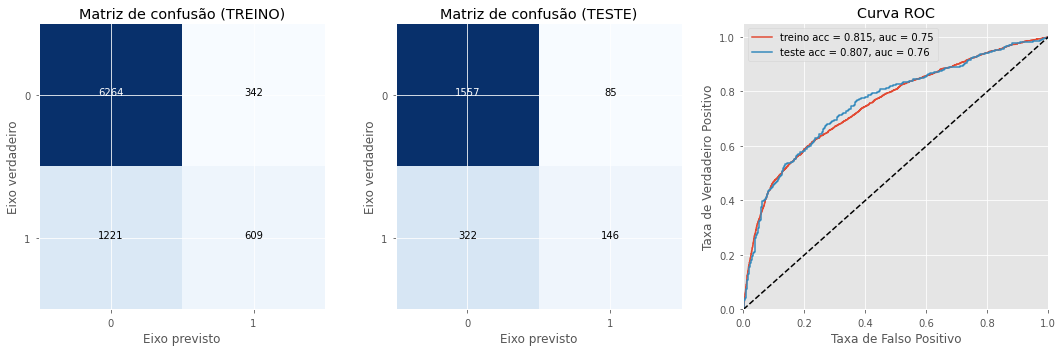

In [39]:

y_train_pred = regr.predict_proba(X_train)[:,1]
y_test_pred = regr.predict_proba(X_test)[:,1]

threshold = 0.5

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Matriz de confusão (TREINO)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Matriz de confusão (TESTE)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

**Random Forest**

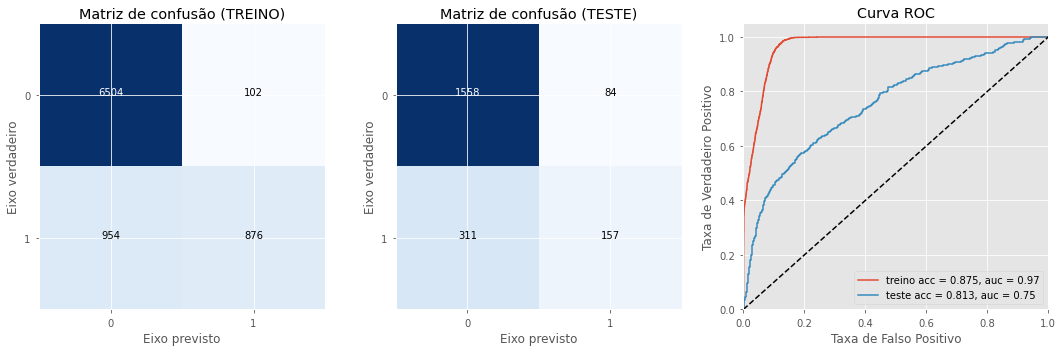

In [45]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score

threshold = 0.5
y_train_pred = rf.predict_proba(X_train)[:,1]
y_test_pred = rf.predict_proba(X_test)[:,1]

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Matriz de confusão (TREINO)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Matriz de confusão (TESTE)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

In [42]:
import xgboost as xgb

In [43]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [44]:
num_round = 5
evallist  = [(dtest,'eval'), (dtrain,'train')]
param = {'objective':'binary:logistic', 'silent':1, 'eval_metric': ['error', 'logloss']}

bst = xgb.train( param, dtrain, num_round, evallist )

[0]	eval-error:0.2	eval-logloss:0.581619	train-error:0.169986	train-logloss:0.573168
[1]	eval-error:0.193365	eval-logloss:0.52257	train-error:0.162755	train-logloss:0.50604
[2]	eval-error:0.189573	eval-logloss:0.489707	train-error:0.162518	train-logloss:0.465909
[3]	eval-error:0.190047	eval-logloss:0.471497	train-error:0.161095	train-logloss:0.439419
[4]	eval-error:0.190047	eval-logloss:0.459384	train-error:0.158606	train-logloss:0.422126


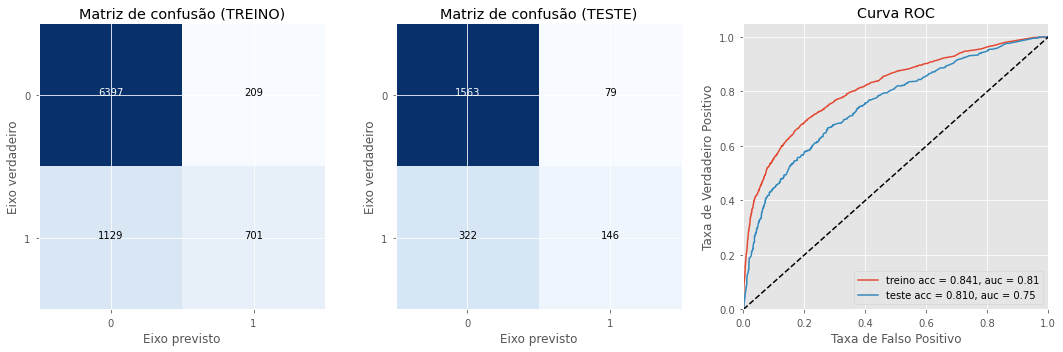

In [46]:
threshold = 0.5
y_train_pred = bst.predict(dtrain)
y_test_pred = bst.predict(dtest)

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Matriz de confusão (TREINO)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Matriz de confusão (TESTE)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()